In [27]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import librosa

from config import ROOT_DIR, WAV_SUBDIR, SEED
from utils import dtw_distance, knn_cross_validate, DTWLookup
from feature_extraction import get_mfcc, get_mel_filterbank, get_window
from data_preprocessing import parse_kaldi_metadata, enrich_metadata, add_features_to_df, knn_extend_labels

# Feature Extraction

We are working with audio files of coughs and breaths, labeled as "positive" and "negative" for COVID-19.

To obtain meaningful input features from the raw audio signals, we extract mel-frequency cepstral coefficients (MFCCs) and log-mel energies. Each audio waveform is first divided into short overlapping frames using a Hamming window, which smooths the edges of each frame to prevent abrupt changes and reduce spectral leakage when computing the Fourier transform. 

The resulting frequency spectra are then passed through a mel filterbank, a series of triangular filters spaced according to the mel scale, designed to approximate the human ear’s perception by emphasizing low frequencies  (more filters in low frequency regions). Then, taking the logarithm of the mel-scaled energy values further compresses the dynamic range, making the features more robust to amplitude variations. Finally, MFCCs are obtained by applying a discrete cosine transform (DCT) to the log-mel energies, producing a compact representation that emphasizes perceptually relevant spectral patterns.


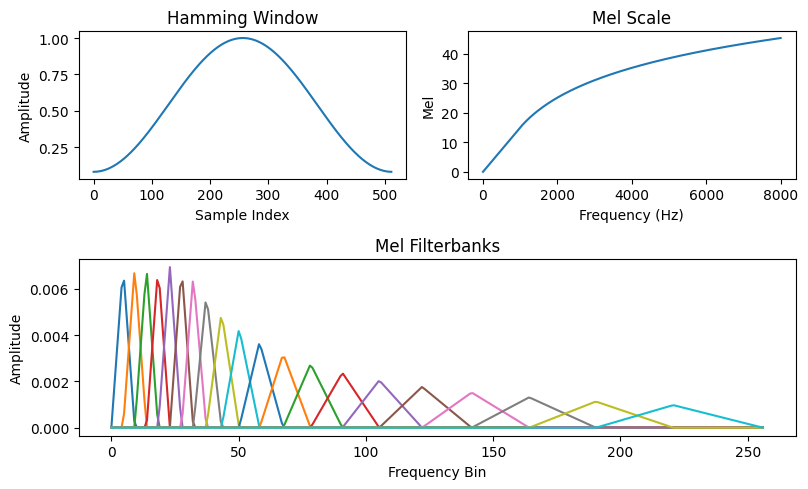

In [6]:
fig = plt.figure(figsize=(8.2, 5))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1.2])

# Plot Hamming window
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(get_window(512, type='hamming'))
ax0.set_title('Hamming Window')
ax0.set_xlabel('Sample Index')
ax0.set_ylabel('Amplitude')

# Plot Mel scale
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(librosa.hz_to_mel(np.arange(8000)))
ax1.set_title('Mel Scale')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Mel')

# Plot Mel filterbanks
mel_fb = get_mel_filterbank(sr=16000, n_fft=512, n_mels=20, fmin=0, fmax=8000)
ax2 = fig.add_subplot(gs[1, :])
for i in range(mel_fb.shape[0]):
    ax2.plot(mel_fb[i])
ax2.set_title('Mel Filterbanks')
ax2.set_xlabel('Frequency Bin')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Data Preprocessing and EDA

We proceed by building a dataframe with the names of our wav files. We heuristically extract the source and audio types of each file from the patterns in the filenames. Each audio is labeled with a positive or negative COVID-19 diagnostic.

In [10]:
train_dir = os.path.join(ROOT_DIR, 'data', 'train')
train_df = parse_kaldi_metadata(train_dir, {'pos': 0, 'neg': 1})
train_df = enrich_metadata(train_df)  # Add source and audio_type columns

In [12]:
sns.set(style="whitegrid", palette="muted")
def plot_histogram(df, column_name, title, xlabel, ylabel="Frequency"):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=column_name, palette="Set2")

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.tight_layout()
    plt.show()

## Exploratory data analysis

We run a quick EDA to see the label, source and audio type distribution.

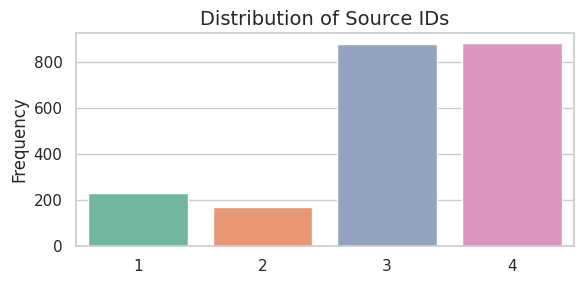

In [13]:
plot_histogram(train_df, 'source_id', 'Distribution of Source IDs', None)

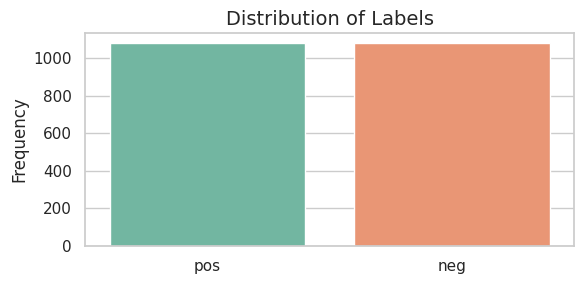

In [14]:
plot_histogram(train_df, 'label', 'Distribution of Labels', None)

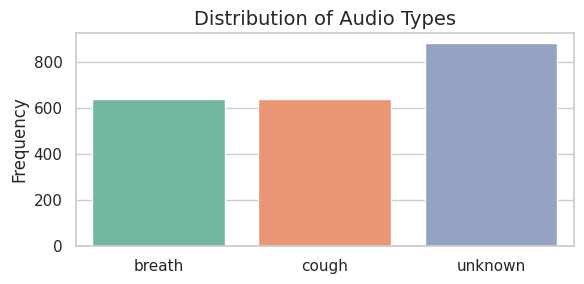

In [15]:
plot_histogram(train_df, 'audio_type', 'Distribution of Audio Types', None)

## Extracting the audio type (cough or breath) with DTW

The audio type for the audios from source 4 can't be extracted from the filenames, and are assigned the "unknown" audio type. We must find an alternative way to figure out whether they are coughs, breaths or neither. For that, we will use the MFCCs, and begin by adding them to the dataframe.

In [18]:
mfcc_params = {
    "n_mfcc": 13,
    "lifter": 22,
    "preemph": 0.97,
    "n_fft": 2048,
    "n_mels": 80,
    "win_size": 0.025,
    "win_stride": 0.01,
    "use_cached": True,
}

train_df = add_features_to_df(train_df, feature_fn=get_mfcc, params=mfcc_params, wav_col="wav_file", out_col="mfcc",  # Add mfcc to df
    save_dir=os.path.join(ROOT_DIR, 'data/features/train/mfcc'), wav_dir=os.path.join(ROOT_DIR, WAV_SUBDIR),
    load_if_exists=True, normalize=True, target_sr=16000, verbose=True)

Processing 0/2160: breath_breaths_0c4dx8rU5G_1586982341272.wav
Processing 100/2160: breath_breaths_RZPXvUslJL_1589264294638.wav
Processing 200/2160: cough_cough_Yarb5WSBeD_1588575071487.wav
Processing 300/2160: 2020-04-07-19_10_35_087599_audio_file_cough.wav
Processing 400/2160: speech_commands_3c6cfda1-3fe9-403d-b5d1-7797420debe2.wav
Processing 500/2160: speech_commands_2405a4e8-af80-4fbf-86c8-4ad9d1731acc.wav
Processing 600/2160: speech_commands_c1d86c76-5622-4dbb-9da1-65aebf6a0f0b.wav
Processing 700/2160: speech_commands_4efe63d6-2447-4bab-a6df-8f95ffaf4a7f.wav
Processing 800/2160: speech_commands_4c86e76d-0476-4016-b26d-00e3b8a0dc01.wav
Processing 900/2160: speech_commands_ccdb32af-58f4-4718-9f6e-eec7e0020382.wav
Processing 1000/2160: speech_commands_34c2c68f-3728-4b17-91a0-2700c1b4fac5.wav
Processing 1100/2160: speech_commands_96d1224b-d75d-4109-a3b6-1cfb07d2e446.wav
Processing 1200/2160: speech_commands_645d6d58-7089-4bee-a2e5-3503f9bbf08c.wav
Processing 1300/2160: kBFDtvAVY9QYbi

In [19]:
file_1 = "tFXAov3QpbTvPL6gzCSwAsTSFT93_breathing-shallow.wav"
file_2 = "LYJToDRYDZfpjBuNC6YkUcphr0q1_cough-shallow.wav"
A = train_df[train_df['wav_file'] == file_1].iloc[0]["mfcc"]
B = train_df[train_df['wav_file'] == file_2].iloc[0]["mfcc"]

# Normalize the MFCCs to (1, n_frames,)
A_flat = np.linalg.norm(A, axis=0)
B_flat = np.linalg.norm(B, axis=0)

# Compute DTW
D, wp = librosa.sequence.dtw(A_flat[np.newaxis, :], B_flat[np.newaxis, :], metric='euclidean')

Once we have the MFCCs, we can use Dynamic Time Warping (DTW), a technique used to measure the similarity between two time series by aligning them, which will allow us to compare similar audio files and extend the audio types to the audios from source 4. We run a simple 1-NN classifier to assign an audio type ("cough" or "breath") to the audios with "unknown" audio type using the samples with known audio type as reference.

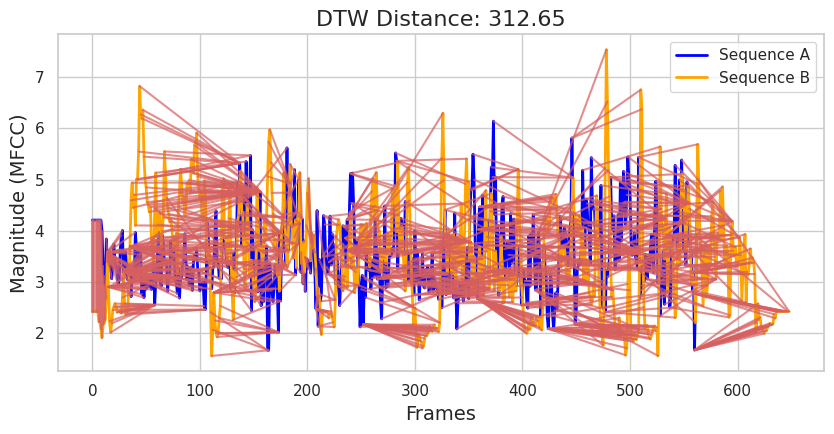

In [20]:
fig, ax = plt.subplots(figsize=(8.5, 4.5))

ax.plot(A_flat, label="Sequence A", color='blue', lw=2)
ax.plot(B_flat, label="Sequence B", color='orange', lw=2)

# Plot the warping path
for i in range(len(wp)):
    ax.plot([wp[i, 0], wp[i, 1]], [A_flat[wp[i, 0]], B_flat[wp[i, 1]]], color='r', alpha=0.7)

ax.set_title(f"DTW Distance: {D[-1, -1]:.2f}", fontsize=16)
ax.set_xlabel("Frames", fontsize=14)
ax.set_ylabel("Magnitude (MFCC)", fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
reference_df = train_df[train_df['audio_type'].isin(['cough', 'breath'])]
target_df = train_df[train_df['audio_type'] == 'unknown']

### Evaluating the 1-NN classifier

We crossvalidate our 1-NN classifier on the labeled data us k-fold CV (with k=5), and get a 77.56% average accuracy.

In [25]:
save_dir = os.path.join(ROOT_DIR, 'data/features/lookups')
filename = "dtw_lookup.pkl"

# Perform k-fold cross-validation on "audio_type" as target
avg_accuracy_audio_type = knn_cross_validate(reference_df, feature_col='mfcc', target_col='audio_type', 
    distance_fn=dtw_distance, lookup_dir=save_dir, filename=filename, k_folds=5, k=1)
                                             
print(f"Average accuracy for 'audio_type' target: {avg_accuracy_audio_type:.4f}")

Fold accuracy: 76.56%
Fold accuracy: 77.34%
Fold accuracy: 79.69%
Fold accuracy: 78.12%
Fold accuracy: 76.08%
Average accuracy: 77.56%
Average accuracy for 'audio_type' target: 0.7756


We also cross-validate this 1-NN classifier for our main purpose, predict the labels of our data (COVID-19 diagnostics), to obtain a simple baseline for this project.

In [26]:
# Perform k-fold cross-validation on "label" as target
avg_accuracy_label = knn_cross_validate(reference_df, feature_col='mfcc', target_col='label_id',
    distance_fn=dtw_distance, lookup_dir=save_dir, filename=filename, k_folds=5, k=1)

print(f"Average accuracy for 'label' target: {avg_accuracy_label:.4f}")

Fold accuracy: 55.47%
Fold accuracy: 61.72%
Fold accuracy: 64.06%
Fold accuracy: 55.86%
Fold accuracy: 61.57%
Average accuracy: 59.74%
Average accuracy for 'label' target: 0.5974


In [28]:
save_dir = os.path.join(ROOT_DIR, 'data/features/lookups')
filename = "dtw_lookup.pkl"
lookup = DTWLookup(save_dir, filename)

target_df = knn_extend_labels(reference_df, target_df, feature_col='mfcc', target_col='audio_type',
    lookup=lookup, distance_fn=dtw_distance, k=1)
                              
lookup.save()

### Filtering out noisy samples

Once we assigned the audio types, we plot the distribution of 1-NN distances to see if there are any samples that correspond neither to coughs nor breaths. From this visualization, it becomes clear that there are audios that correspond to noise, so we will remove the audio files with a 1-NN distance higher than 20.

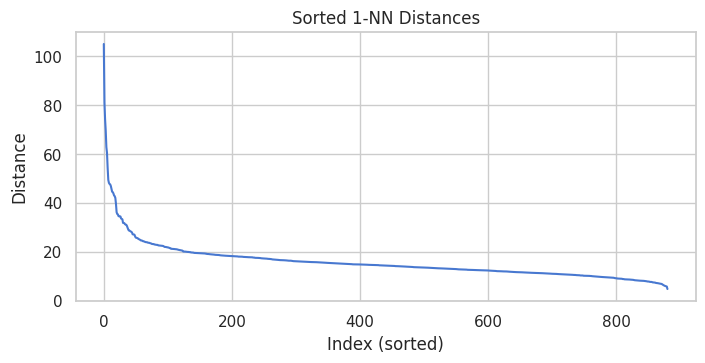

In [29]:
import matplotlib.pyplot as plt
import numpy as np

distances = target_df["1nn_closest"].values
dist_sorted = np.sort(distances)[::-1]   # sort descending

plt.figure(figsize=(8, 3.5))
plt.plot(dist_sorted)
plt.title("Sorted 1-NN Distances")
plt.xlabel("Index (sorted)")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

In [30]:
threshold = 20
filtered_df = target_df[target_df["1nn_closest"] <= threshold].copy()
filtered_clean = filtered_df.drop(columns=["1nn_closest"]).copy()
train_df = pd.concat([reference_df, filtered_clean], ignore_index=True)

All the data in our `train_df` now has a valid audio type assigned.

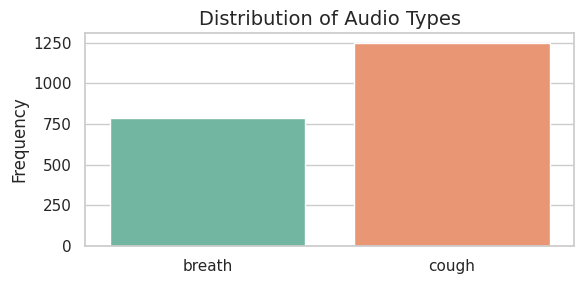

In [31]:
plot_histogram(train_df, 'audio_type', 'Distribution of Audio Types', None)

### Test data

We now repeat the process for our test data.

In [32]:
test_dir = os.path.join(ROOT_DIR, 'data', 'test')
test_entries = parse_kaldi_metadata(test_dir, {'pos': 0, 'neg': 1})
test_entries = enrich_metadata(test_entries)

df_test = add_features_to_df(test_entries, feature_fn=get_mfcc, params=mfcc_params, wav_col="wav_file", out_col="mfcc",
    save_dir=os.path.join(ROOT_DIR, 'data/features/test/mfcc'), wav_dir=os.path.join(ROOT_DIR,WAV_SUBDIR),
    load_if_exists=True, normalize=True, target_sr=16000, verbose=True)

Processing 0/462: breath_breaths_pIs0irifZL_1588424717177.wav
Processing 100/462: speech_commands_30f761c8-b6fd-4e2a-bf25-0e5cde6102be.wav
Processing 200/462: speech_commands_210860ed-f80a-4ae2-ae9c-2a67ff637388.wav
Processing 300/462: YgKJK1UxM6NMjfugUnV4mi50d732_breathing-shallow.wav
Processing 400/462: Z6qimRi4c2NDdPHsocMRk9IlgdH2_cough-shallow.wav


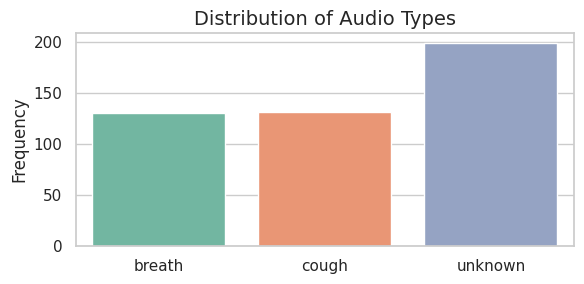

In [33]:
plot_histogram(df_test, 'audio_type', 'Distribution of Audio Types', None)

In [34]:
test_ref_df = df_test[df_test['audio_type'].isin(['cough', 'breath'])]
target_df = df_test[df_test['audio_type'] == 'unknown']

### Evaluating the 1-NN classifier

We evaluate our 1-NN classifier on the audio files with an audio type from the test set, to see how accurate it is. We obtain a 81.37% accuracy.

In [95]:
avg_accuracy_audio = knn_eval(train_df, test_ref_df, feature_col='mfcc', target_col='audio_type',
    distance_fn=dtw_distance, lookup_dir=save_dir, filename=filename, k_folds=5, k=1)

print(f"Average accuracy for 'audio_type' target: {avg_accuracy_audio:.4f}")

Accuracy: 81.37%
Average accuracy for 'audio_type' target: 0.8137


We do the same, this time predicting the COVID-19 diagnosis. A 52.09% is barely above the random baseline (50%), which shows this 1-NN classifier is not a good way to predict the label of the data.

In [96]:
avg_accuracy_audio = knn_eval(train_df, test_ref_df, feature_col='mfcc', target_col='label',
    distance_fn=dtw_distance, lookup_dir=save_dir, filename=filename, k_folds=5, k=1)

print(f"Average accuracy for 'label' target: {avg_accuracy_audio:.4f}")

Accuracy: 52.09%
Average accuracy for 'label' target: 0.5209


In [98]:
lookup = DTWLookup(save_dir, filename)

target_df = knn_extend_labels(reference_df, target_df, feature_col='mfcc',  # use "reference_df" from train
    target_col='audio_type', lookup=lookup, distance_fn=dtw_distance, k=1)

lookup.save()

### Filtering out noisy samples

We repeat the same process for test samples, extending valid types to files with "unknown" audio type, and see how again the threshold of 20 1-NN distance is a good number to filter out the noisy data (from the distributions of the distance and accuracy of our classifier, we can safely say audio files with a 1-NN distance above 20 are likely neither coughs nor breaths).

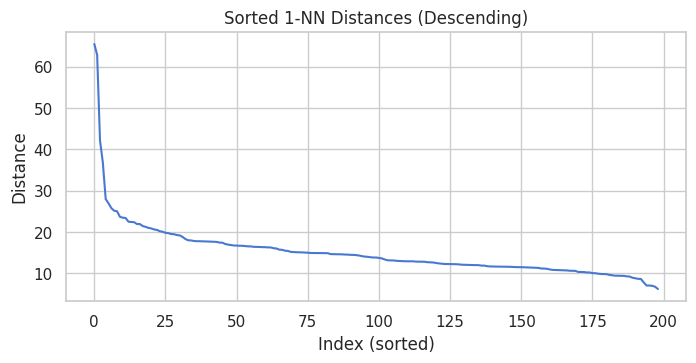

In [99]:
import matplotlib.pyplot as plt
import numpy as np

distances = target_df["1nn_closest"].values
dist_sorted = np.sort(distances)[::-1]   # sort descending

plt.figure(figsize=(8, 3.5))
plt.plot(dist_sorted)
plt.title("Sorted 1-NN Distances (Descending)")
plt.xlabel("Index (sorted)")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

In [101]:
threshold = 20
filtered_df = target_df[target_df["1nn_closest"] <= threshold].copy()
filtered_clean = filtered_df.drop(columns=["1nn_closest"]).copy()
test_df = pd.concat([test_ref_df, filtered_clean], ignore_index=True)

All the data in our `test_df` now has a valid audio type assigned.

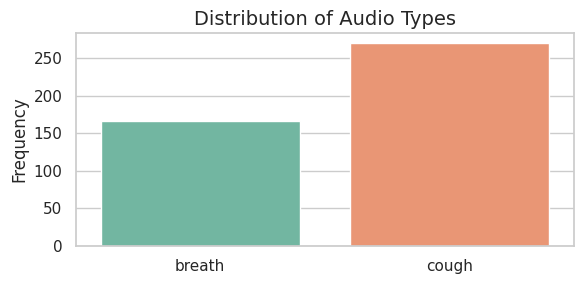

In [102]:
plot_histogram(test_df, 'audio_type', 'Distribution of Audio Types', None)